# Machine Learning in Python - Group Project 1

Contributors:
* Thomas Lanning
* Alexander Bohane
* Mengyao 
* Shangyung

## General Setup

These are the packages we will be using and what pip installations we might have to do.

In [1]:
# From the instructions, we can see that the data is taken from this library (but then modified) so we install this
# package and use the data for feature engineering!
#!pip install schrutepy

#!pip install nltk
#!pip install imbalanced-learn

In [2]:
# Add any additional libraries or submodules below

import warnings
warnings.filterwarnings('ignore')

# Data libraries
import numpy as np
import pandas as pd
from schrutepy import schrutepy
import itertools

# Sentiment Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# download the vader lexicon 
#nltk.download('vader_lexicon')

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [3]:
# sklearn modules that are necessary
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer


In [4]:
# First we load the data 
data = pd.read_csv("the_office.csv")
# and our external data from SchrutePy. (Referenced at end)
data_from_schrutepy = schrutepy.load_schrute()

## 1. Introduction

The task for this project is to use data from the TV show "The Office" to build a predictive model that captures the underlying relationships between various features and the audience ratings, with the goal of advising NBC Universal on how to produce the highest-rated reunion episode possible. The data is provided in a CSV file, and additional sources were used by us. 

Following the link on the assignement to Schrutepy, we are able to extract the original dataset. This is vital to our feautre engineering since we want to consider the importance of character presence on the rating. The idea being that if certain characters dominated the episodes, this could have significant influence on ratings. 

Additionaly, we wanted a feature to decide if an episode was emotional (in a positive or negative way). To do this, we used sentiment analysis provided by the Vader Lexicon from https://www.nltk.org/. Using this lexicon, we can have a rough estimate on weather our episodes are positive or negative. More information on the specifics can be found on their website.

The approach we used was following the standard ML process. First we have our exploratory data analysis, followed by our feature engineering. We decide what features we think are relevant, what features are co-dependent and so conclude what our final data to feed into the model will look like. 

After we have our final dataframe, we split it into test and training data and apply different models to our training data to find the optimal parameters. Having then found our model, we test its performance on the testing data. From our model, we can find the most important features which affect our episode rating and thereby can conclude what we want to see in a reunion episode. 

We present to NBC Universal several different proposals on what should be the writer, director, what main characters appear, how many characters should speak, and how positive or negative the script should be. (more on this later)

## 2. Exploratory Data Analysis and Feature Engineering

### 2.1 Exploratory Data Analysis

First we will explore the given dataset and show what the SchrutePy dataset looks like, which we downloaded from the package SchrutePy (reference below). This was hinted at in the instructions and will give us extra data to make our model.

Below is the given dataset from the_office.csv

In [5]:
data.head(2)

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...


And here is the external dataset we use from SchrutePy:

In [6]:
data_from_schrutepy.head(2)

,index,season,episode,episode_name,director,writer,character,text,text_w_direction
0,1,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...
1,2,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So..."


This gives us a quick overview of what our columns are, how the data is inputted and how the overall structure of the data is. This is important for us so we can create efficient code later!
Now lets quickly describe our data:

In [7]:
display(data.describe().T.round(2))

,count,mean,std,min,25%,50%,75%,max
season,186.0,5.46,2.40,1.0,3.00,6.0,7.75,9.0
episode,186.0,12.48,7.23,1.0,6.00,12.0,18.00,28.0
imdb_rating,186.0,8.25,0.54,6.7,7.90,8.2,8.60,9.7
total_votes,186.0,2129.54,790.79,1393.0,1628.50,1954.0,2385.00,7934.0
n_lines,186.0,296.40,82.00,131.0,255.25,281.0,314.50,625.0
n_directions,186.0,50.15,23.94,11.0,34.00,46.0,60.00,166.0
n_words,186.0,3053.51,799.27,1098.0,2670.25,2872.5,3141.00,6076.0
n_speak_char,186.0,20.69,5.09,12.0,17.00,20.0,23.00,54.0


We can see we have 186 episodes in total, average rating of 8.25 (good show), several other parameters which will be important later when we feature engineer. We can see for example there is quite a large standard deviation in the amount of votes, which could skew our ratings. We also see our rating (target variable) has a standard deviation of 0.54, whereas the mean is 8.25. This shows there is enough spread of rating to make non-uniform predictions.

Are there any missing values?

In [8]:
print('The DataFrame: data, has ',data.isna().sum().sum(),' NaN values')

The DataFrame: data, has  0  NaN values


What about our external dataset?

In [9]:
data_from_schrutepy.isna().sum()

index                 0
season                0
episode               0
episode_name          0
director              0
writer                0
character             0
text                374
text_w_direction      5
dtype: int64

We can see we have the columns text and text_w_directions have NaN values. However, we will not be using these anyways since its just the script! So we do not have to worry about it :)

In [10]:
# We will no get our numerical data so we can visualize it:
num_data = data.copy()
num_data = num_data.drop(columns = ['episode_name', 'director', 'writer', 'air_date', 'main_chars'])

Now lets take a look at the distribution of the columns. (except of course the season number, episode, and air date)

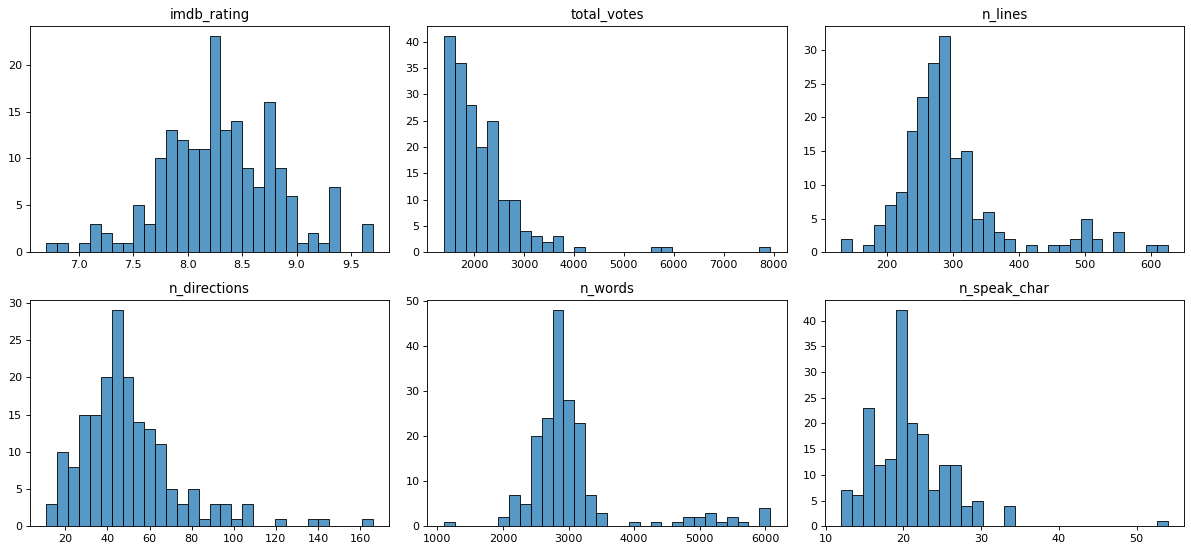

In [11]:
fig, axes = plt.subplots(figsize=(15,7), ncols=3, nrows=2)
axes = axes.flatten()

#define our columns
lst = ['imdb_rating','total_votes', 'n_lines', 'n_directions','n_words', 'n_speak_char']

for i, ax in enumerate(axes):
    sns.histplot(data = num_data[lst[i]], bins=30, ax=ax)
    ax.set_title(num_data[lst[i]].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

The graphs above allow us to visualise the distributions of all of our numerical features. We can see that some features are skewed and others follow a normal gaussian distribution. From this information, we will implement a transformation to transform all non-gaussian features to gaussian. This will be done in the feature engineering section. Doing so will improve the predictions made by our linear regression model further down the line. 


Now before we move on to visualizing the correlation between variables, we want to see a breakdown of the relationship between writers and directors. After group discussion, we already know we want to include writers and directors in our model, but we need to make encoding of these variables. 

What is important to us is not the directors which had one hit wonders: i.e. the directors which had directed one episode and got lucky with a good rating. Maybe they are really good, but we are looking for consistency. The director for our final episode has to be consistently good.

<b> We set a threshold to choose which directors to encode in our model:</b> we want directors to have directed at least ***5 shows*** and then from there select the ***best 5***  

In [12]:
#get director dataframe which has their ratings and get a new column calculating the amount of times they directed
director = data[['director', 'imdb_rating']].reindex(columns=list(['director', 'imdb_rating', 'freq']), fill_value=1)
#calculates the sum
director = director.groupby('director')[['director', 'imdb_rating', 'freq']].sum() 
director['mean_rating'] = round(director['imdb_rating'] / director['freq'], 2)
# and sort the values for us on frequency (explained below) with a mean rating in the 75% percentile. 
director[director['freq']>=5].drop(columns = 'imdb_rating').sort_values(by='mean_rating', ascending=False).head(6)

,freq,mean_rating
director,,
Paul Feig,14,8.69
Ken Kwapis,12,8.54
Greg Daniels,14,8.52
Ken Whittingham,8,8.36
Charles McDougall,6,8.30
Jeffrey Blitz,11,8.30


We find that using this criteria, we get some of the consistnently best directors. Fortunately for us, we can see that all our directors with high frequency also have fairly good ratings, with Paul Feig having a very high rating consistently! We see that Jeffery Blitz has the same rating as Charles McDougall so we use Jeffery since he has a higher frequency!

Now lets do the same with writer. Here some times the writers collab. We will NOT split up the writers individually because we believe collaborations between writers can lead to better results than the writers individually together!

In [13]:
#get director dataframe which has their ratings and get a new column calculating the amount of times they directed
writer = data[['writer', 'imdb_rating']].reindex(columns=list(['writer', 'imdb_rating', 'freq']), fill_value=1)
#calculates the sum
writer = writer.groupby('writer')[['writer', 'imdb_rating', 'freq']].sum() 
writer['mean_rating'] = round(writer['imdb_rating'] / writer['freq'], 2)
# and sort the values for us on frequency (explained below) with a mean rating in the 75% percentile. 
writer[writer['freq']>=5].drop(columns = 'imdb_rating').sort_values(by='mean_rating', ascending=False).head(6)

,freq,mean_rating
writer,,
Greg Daniels,9,8.74
Gene Stupnitsky;Lee Eisenberg,7,8.51
Michael Schur,7,8.49
Paul Lieberstein,13,8.40
B.J. Novak,15,8.37
Lee Eisenberg;Gene Stupnitsky,6,8.35


Using the same reasoning, we can find the best consistently best 5 writers which we will choose to encode!

Now that we have done all of this: It is time to see the correlation between our variables so we can choose the best selection for our model to reduce feature dependence!

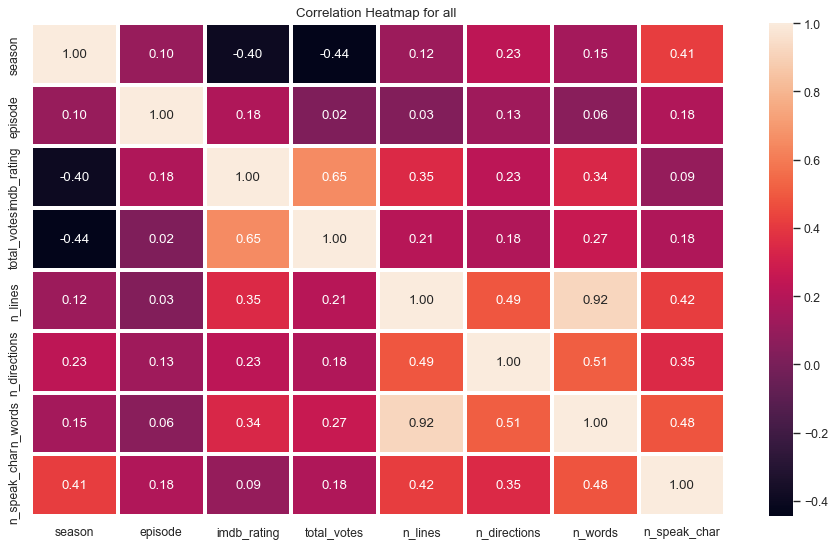

In [14]:
#heatmap
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(num_data.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap for all ")
plt.show()

We can see some very important things to reduce colinearity/codependence:

* n_lines and n_words is very highly correlated (obviously) so we will deal with that later. Other n_* lines are also slightly correlated so we will find a way to deal with those too.
* imbd_rating and total_votes is also very highly correlated. 
    + We need to be careful here because this implies episodes with a large number of votes often is rated more highly. We cannot have number of votes as an input variable in our model because for a reunion episode, we obviosuly cannot say a priori the amount of votes we will get. To deal with this we will look deeper into the problem: We can adjust the imdb rating based on the amount of votes it got or choose to ignore the correlation if we find the relationship to be insignificant. More on this later...
* The same is with rating and season number. However, since we cannot account for the season number in our reunion episode, we cannot do anything about this either. We could weight each season to imbd rating but do not believe this to be outside the scope of this project. It would be great for further research!

Firstly, lets look at how we can deal with number of episodes, words, lines, etc.

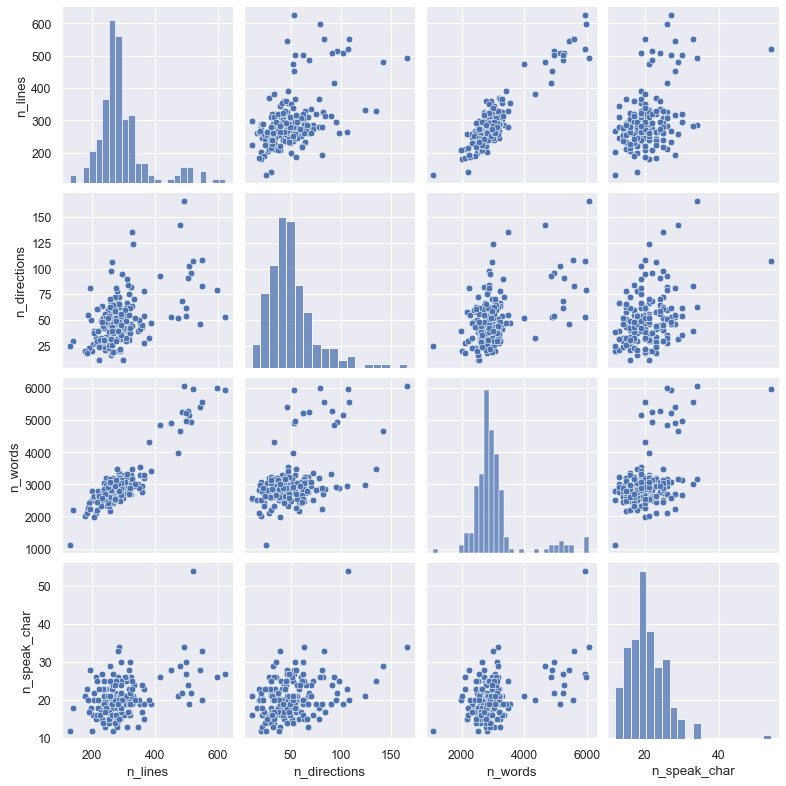

In [15]:
# we now want to see how the highly correlated values are relates:
sns.pairplot(data[['n_lines','n_directions','n_words', 'n_speak_char']])

We can see a very clear __linear__ relationship between n_lines and n_words which is good for us since it means we can combine or eliminate one of those feautres. The other variables we do not see as strong relationship so we are hesitant to eliminate those. We will see if testing the model on a reduced parameter space will improve performance later, in which we can reduce some of these feautures.

### 2.2 Feature Engineering

#### Features we are eliminating (from the_office.csv) and why:
* We will eliminate the column n_words since we found that n_lines and n_words were highly linearly correlated. Doing so will reduce collinearity in our final model. 
* We will remove season number, episode number and air_date because this is not applicable to the reunion episode. We consider our personal experience and realize most of the office nowadays is watched through streaming services, which are independent of air date. We do however acknowledge that the rating could be dependent on air_time and season numbers, although marginally

#### Features we will engineer:
* We want to see how many times do the main characters talk during the episode and see if it effects the rating.
    * We simultaneously drop the remove the column n_lines by dividing character lines per episode by total lines per episode. This way we can get the character presence in each episode in percentage scale.
* We want to OneHotEncode the top 5 writers and directors


#### Will we adjust the IMDB rating according to the number of votes and season number to evenly weight the ratings for our model?
As a group, we have decided to leave this for future expansion. We acknowledge the correlation between votes and episode number. We think this is because a very good episode will motivate more people to vote. We have discussed promoting voting on episodes as part of the advertisment for the reunion episode in the hopes that this might boost the rating. However, we also acknowledge large number of votes might not be mean __causation__ for a high rating.

#### Finally, we will standardise all of our final numerical features

#### 2.2.1 How many times do characters speak?

We can get this data from our external source: data_from_schrutepy

In [16]:
# make a data which is how many times does {Character} speak in each episode?
speak_count = pd.DataFrame(data_from_schrutepy.groupby(by=['season','episode','character']).count()['text']).unstack()
speak_count.head(1)

text                                          \
character      "Angela" "Jim" "Jo" "Phyllis" (Pam's mom) Heleen   
season episode                                                    
1      1            NaN   NaN  NaN       NaN                NaN   

                                                                   \
character      3rd Athlead Employee 4th Athlead Employee A.J.  AJ   
season episode                                                      
1      1                        NaN                  NaN  NaN NaN   

                              ...                                          \
character      Aaron Rodgers  ... Worker Wrangler Young Man Young Michael   
season episode                ...                                           
1      1                 NaN  ...    NaN      NaN       NaN           NaN   

                                                     
character      Younger Guy Zeke Zion abe sAndy song  
season episode                                       
1      1               NaN  NaN  NaN NaN   NaN  NaN  

[1 rows x 773 columns]

We can see that we now have 773 characters in the office, most of which do not speak: a lot of minor characters we do not wish to include in our model. So now lets filter the main characters only: this can be found in the the_office.csv file.

In [17]:
#correlate this to the main characters in this episode (from the_office.csv) and delete all minor characters
a = data.main_chars.str.split(';')
#this gets all the unique main characters from the_office.csv and save it as main_characters
main_characters = list(itertools.chain.from_iterable(a))
main_characters = pd.DataFrame(main_characters).drop_duplicates().reset_index()[0]

# adjust the dataFrame index
speak_count = speak_count.reset_index(names = ['episode','season', 'character'], col_level=1)
# get just the main character
speak_count_main_characters = speak_count['text'][main_characters].fillna(0)
speak_count_main_characters.head()
#then add the main characters to the model input data!
data[speak_count_main_characters.columns] = speak_count_main_characters
data.head(2)

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,...,Phyllis,Ryan,Stanley,Kelly,Toby,Meredith,Darryl,Creed,Andy,Erin
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,...,2.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,...,0.0,4.0,5.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0


As we can see, this worked out really well! We now have extra columns which shows how often the main characters speak in the show per episode!

Below we can show a visual representation of how many times each main character speaks!

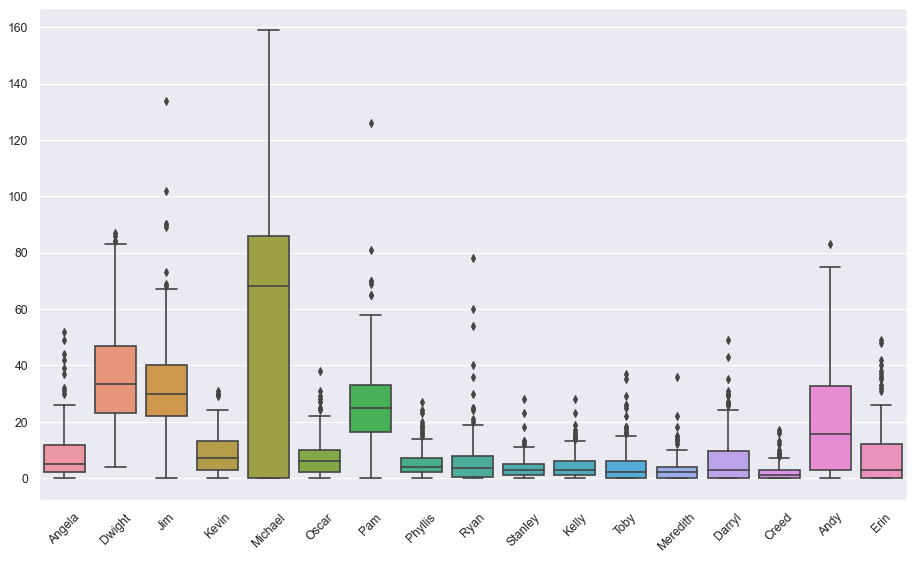

In [18]:
sns.boxplot(data[main_characters])
plt.xticks(rotation=45) # rotate x-labels 45 degrees
plt.show()

We can see there are a lot of outliers. This shows some episodes focus on specific characters. As a future improvement we might want to eliminate these outliers. 

We can also see the strong presence of micheal (the main character). Interesting to see that Dwight has appeared in **every** episode. 

#### 2.2.2 One Hot Encode the writers and directors:

It is now time to one hot encode the important writers and directors we found in the EDA section.

In [19]:
# First we define the directors and writers we are looking 
directors = ['Paul Feig','Ken Kwapis','Greg Daniels','Ken Whittingham','Jeffrey Blitz']
writers = ['Greg Daniels','Gene Stupnitsky;Lee Eisenberg','Michael Schur','Paul Lieberstein','B.J. Novak']

In [20]:
# perform encoding on the director column
encoded = pd.get_dummies(data['director'].apply(lambda x: x if x in directors else 'Other_director'))
encoded = encoded.rename(columns={"Greg Daniels": "Greg Daniels (director)"})

# merge the encoded dataframe with the original dataframe
data = pd.concat([data, encoded], axis=1)

# drop the original director column and the other director since it is indirectly encoded in the other columns
data.drop(['director', 'Other_director'], axis=1, inplace=True)

data.head(1)

,season,episode,episode_name,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,...,Meredith,Darryl,Creed,Andy,Erin,Greg Daniels (director),Jeffrey Blitz,Ken Kwapis,Ken Whittingham,Paul Feig
0,1,1,Pilot,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0


In [21]:
#now lets do the same but with the writers!
# perform encoding on the director column
encoded = pd.get_dummies(data['writer'].apply(lambda x: x if x in writers else 'Other_writer'))
encoded = encoded.rename(columns={"Greg Daniels": "Greg Daniels (writer)"})

# merge the encoded dataframe with the original dataframe
data = pd.concat([data, encoded], axis=1)

# drop the original writer column and the other_writer for same reason as above
data.drop(['writer','Other_writer'], axis=1, inplace=True)

data.head(1)

,season,episode,episode_name,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,...,Greg Daniels (director),Jeffrey Blitz,Ken Kwapis,Ken Whittingham,Paul Feig,B.J. Novak,Gene Stupnitsky;Lee Eisenberg,Greg Daniels (writer),Michael Schur,Paul Lieberstein
0,1,1,Pilot,7.6,3706,2005-03-24,229,27,2757,15,...,0,0,1,0,0,0,0,0,0,0


#### 2.2.3 Dropping our Unessecary Columns

Its now time to get rid of season, episode,episode_name,total_votes	and air_date so we can start to deal with the numbers of words and votes

In [22]:
data = data.drop(columns=['season', 'episode', 
                          'episode_name','total_votes',
                         'air_date', 'main_chars'])

#### 2.2.4 What to do with n_lines and n_words

We know from our correlation matrix that these two are highly linearly correlated. That is why we will drop the n_words column (we could also have dropped n_lines instead). 

We will also know create a copy of our dataFrame to start working on the model with

In [23]:
data = data.drop(columns=['n_words'])

Next we will do some combination feature engineering and combine n_lines with the number of lines that a specific character speaks in each episode. To do this we will divide the number of lines each character speaks by the number of lines in each episode. Then we will remove the n_lines column after combination. The resultant metric can be thought of as the character presence and qualitatively represents the percentage of total lines that a specific main character speaks per episode.

In [24]:
data.iloc[:,4:21] = data.iloc[:,4:21].div(data.iloc[:,1], axis=0)
data = data.drop(["n_lines", "n_directions"], axis = 1)

#### 2.2.5 Sentiment Score

We now will run the sentiment analysis on the script per episode. This uses the Vader dictionary to determine how happy/neutral/sad a given script is! The exact details of the sentiment scorer can be found on their website. However in a nutshell:

The sentiment analyzer from NLTK is a tool that can analyze the sentiment of a piece of text by assigning a polarity score to it between 0 and 1 for both how negative and neutral a scoring is. The sentiment analyzer uses various techniques such as tokenization, part-of-speech tagging, and machine learning algorithms to determine the overall sentiment of a text.

And we will use it on our script!

In [25]:
# instantiate the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# define the text to analyze (fill the silences (nan) with  ' ')
text = data_from_schrutepy.fillna(' ').groupby(['season', 'episode'])['text'].apply(' '.join)

# analyze the sentiment of the text
scores = [analyzer.polarity_scores(i) for i in text]

In [26]:
# get the positive and negative sentiment scores
data['pos_score'] = [scores[i]['pos'] for i in range(len(scores))]
data['neg_score'] = [scores[i]['neg'] for i in range(len(scores))]

## 3. Model Fitting and Tuning

In this section, we will choose an appropriate model, tune it and ultimately get a model that can give us a reliable predict of `imdb_rating` and provide a perspective of producing a popular episode.

### 3.1 User Defined Helper Functions

Firstly, we define some functions, which is useful in the following process.

In [28]:
def tidy_scores(score_dict):
    """Transform the cross_validation results into a dataframe and calculate the mean score and the standard deviation.
    """
    
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

In [29]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model
    based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    res = pd.DataFrame(data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat})
    
    if plot:
        plt.figure(figsize=(10, 5))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [30]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
     
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

### 3.2 Model Choosing

In [31]:
df = data.copy()

We tried linear regression, regression trees, Lasso regression, Ridge regression and K-nearest-neighbor regression. After analyzing and comparing their performance, we finally choose Lasso regression model. The reason why others are rejected is detailed as follows:
- For linear regression, its $R^2$ of training set is much higher than that of validation set and sometimes the validation score is even negative, which is an obvious sign of overfitting. Also, there is no hyperparameter that helps mitigate overfitting, so we won't use it.
- Regression tree shows more severe overfitting. Its $R^2$ of training set is up to 1 but in validation set, $R^2$ is close to 0.
- For Ridge regression and K-nearest-neighbor regression, we compare their $R^2$ and its standard deviation in both training set and validation set, and finally choose the best one among them, which is Lasso regression model.

With Lasso regression, we first split our data into training set and test set. The size of the test set is 20% of all data.

In [32]:
X = df.drop(['imdb_rating'], axis = 1)
y = df['imdb_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Then we use lasso regression with hyperparameter $\alpha = 0.1$ (selected randomly) to fit our training data. 

The lasso method requires initial standardization of the regressors, so that the penalization scheme is fair to all regressors. So we need to scale *all* features by `StandardScaler()`, and now the feature values can be interpreted as the number of standard deviations each observation is away from that column's mean.

In [33]:
scaler = StandardScaler()    # used to standardize our regressors

lasso = Pipeline(steps = [("scaler_tranform", scaler),
                          ("model", linear_model.Lasso(alpha = 0.1, random_state = 42))])

lasso_model_ori = lasso.fit(X_train, y_train)

Now we see the performance metrics of our model, which is easily obtained by the pre-defined function.

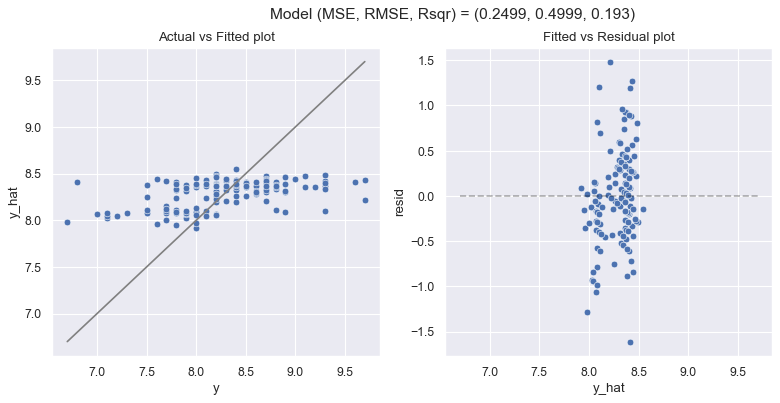

(0.249928961809501, 0.4999289567623594, 0.19295031614863178)

In [34]:
model_fit(lasso_model_ori, X_train, y_train, plot = True)

The value of $R^2$ is lower than 0.2, which means that our model can only explain less than 20% of variation of our training data. The values of MSE and RMSE seem low, but it is probably due to the small data range of `imdb_rating`.

Another thing we care about is whether our model is validate for other data. So we carry out cross validation with `scoring = r2` and `scoring = neg_root_mean_squared_error`.

In [35]:
# we choose 3-fold
kf = KFold(n_splits = 3, shuffle = True, random_state=42)

# cv results with scoring = r2
scores_ori1 = cross_validate(lasso, X_train, y_train, cv = kf, return_train_score = True)

# transform our cv results into a dataframe by the pre-defined function
tidy_scores(scores_ori1)

,fit_time,score_time,val_score,train_score
fold,,,,
0,0.0,0.0,0.05,0.24
1,0.0,0.0,0.21,0.24
2,0.0,0.0,0.16,0.16
mean,0.0,0.0,0.14,0.22
sd,0.0,0.0,0.07,0.04


There is an obvious drop in validation $R^2$, which implies the probability of overfitting. The increasement in the standard deviation of $R^2$ of validation sets indicates that our model is not very stable. This also can be seen clearly from the results of each fold.

In [36]:
# cv results with scoring = neg_root_mean_squared_error
scores_ori2 = cross_validate(lasso, X_train, y_train, cv = kf, return_train_score = True,
                            scoring = 'neg_root_mean_squared_error')

tidy_scores(scores_ori2)

,fit_time,score_time,val_score,train_score
fold,,,,
0,0.0,0.0,-0.60,-0.45
1,0.0,0.0,-0.43,-0.51
2,0.0,0.0,-0.50,-0.51
mean,0.0,0.0,-0.51,-0.49
sd,0.0,0.0,0.07,0.03


Compared with $R^2$, negative RMSE tells us similar information. So in the following process, we will only use `scoring = r2` for cross validation.

### 3.3 Model Tuning

We start with the model that provides a poor fit and then we want to tune it to see whether we can improve its performance.

#### 3.3.1 Model with best hyperparameter

There is a hyperparameter $\alpha$ in Lasso regression model. In the previous model, we choose a value without much consideration. Now we want to find the optimal alpha, which can minimize the error (RMSE) of our model.

In [37]:
# 200 alphas from 0.01 to 10
alphas = np.logspace(-2, 1, num=200)

gs = GridSearchCV(make_pipeline(scaler, linear_model.Lasso(random_state = 42)),
    param_grid = {'lasso__alpha': alphas}, cv = kf, scoring = "neg_root_mean_squared_error")

gs.fit(X_train, y_train)
print(gs.best_params_)

{'lasso__alpha': 0.034891012134067735}


With the optimal $\alpha$, we run the lasso regression model again and see its performance.

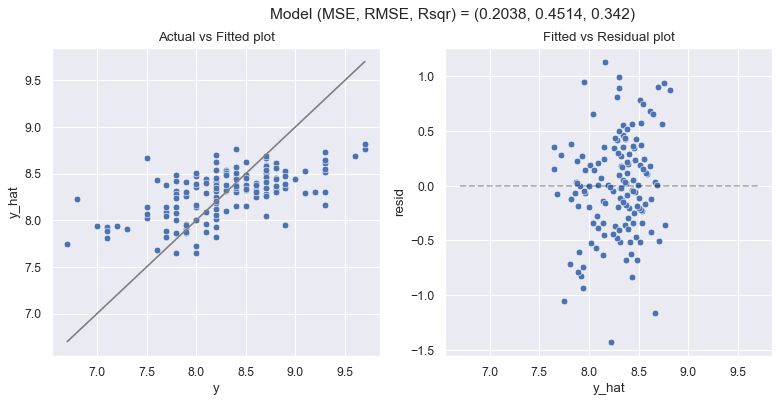

(0.20378262550580697, 0.4514228898780023, 0.3419622027869711)

In [38]:
best_alpha = gs.best_params_['lasso__alpha']
lasso = Pipeline(steps = [("scaler_tranform", scaler),
                          ("model", linear_model.Lasso(alpha = best_alpha, random_state = 42))])
lasso_model = lasso.fit(X_train, y_train)
model_fit(lasso_model, X_train, y_train, plot = True)

Fortunately, the graphs seem more reasonable and the model error (MSE and RMSE) decreases. Also, $R^2$ is improved, but it is still low. We will continue to tune our model in the next part. Now we focus on the model validation.

In [39]:
# cv with scoring = r2
scores = cross_validate(lasso, X_train, y_train, cv = kf, return_train_score = True)
tidy_scores(scores)

,fit_time,score_time,val_score,train_score
fold,,,,
0,0.0,0.0,0.06,0.40
1,0.0,0.0,0.12,0.45
2,0.0,0.0,0.32,0.30
mean,0.0,0.0,0.16,0.38
sd,0.0,0.0,0.11,0.06


The train score becomes much larger and validation score also has a slight rise. But the gap between train and validation widens. The standard deviation of $R^2$ also increases. The model is still not stable and the difference between the performance of the training set and the validation set is large.

#### 3.3.2 Model with interactions

To improve the performance of our model, we consider adding the interaction features by `PolynomialFeatures()`. To avoid over-complexity, we set `degree = 2` (defaulted).

In [40]:
poly = PolynomialFeatures(include_bias=False,interaction_only = True)

Similarly, we find the optimal $\alpha$ first.

In [41]:
# 200 alphas from 0.1 to 1
alphas = np.logspace(-1, 0, num=300)
# find lasso's optimal alpha
gs = GridSearchCV(make_pipeline(poly,linear_model.Lasso(random_state = 42)),
    param_grid = {'lasso__alpha': alphas}, cv = kf, scoring = "neg_root_mean_squared_error")

gs.fit(X_train, y_train)
print(gs.best_params_)

{'lasso__alpha': 0.1403321537605485}


With the optimal $\alpha$, we fit the model with interaction features. The performance matrics are shown below.

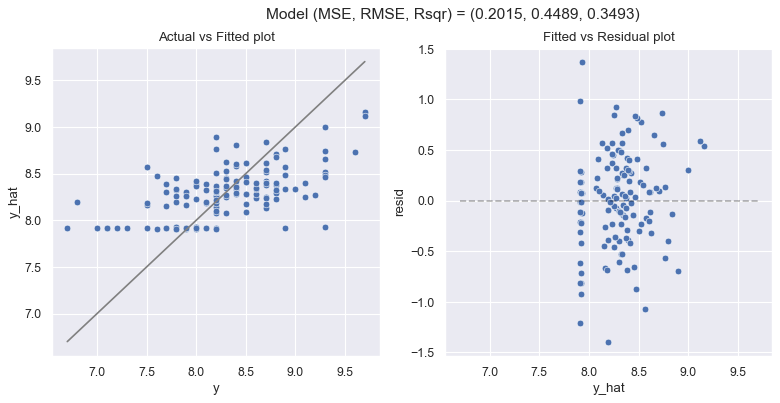

(0.20150333710823967, 0.4488912308212755, 0.34932229009876026)

In [42]:
best_alpha = gs.best_params_['lasso__alpha']
lasso = Pipeline(steps = [("poly", poly),
                          ("model", linear_model.Lasso(alpha = best_alpha, random_state = 42))])
lasso_model_inter = lasso.fit(X_train, y_train)
# plot
model_fit(lasso_model_inter, X_train, y_train, plot = True)

Though by comparison of MSE, RMSE and $R^2$, we find that the performance of this model has improved slightly, the strange straight line among low $y$ shows that our model does not have the ability to explain the data when the `imdb_rating` is relatively low.

Now we look at the model validation.

In [43]:
scores_inter = cross_validate(lasso, X_train, y_train, cv = kf, return_train_score = True)
tidy_scores(scores_inter)

,fit_time,score_time,val_score,train_score
fold,,,,
0,0.00,0.0,0.14,0.39
1,0.01,0.0,0.17,0.43
2,0.00,0.0,0.37,0.29
mean,0.00,0.0,0.22,0.37
sd,0.00,0.0,0.10,0.06


The validation score increases and the gap between training and validation narrows. The results of cross validation improved, but as we discussed before, this model provides a pretty poor fit when $y$ is low. We desire a model that is applicable for the whole range of $y$, so we prefer the model without interaction features.

### 3.4 Final Model

Finally, we choose the model we presented in section 3.3.1, i.e., Lasso regression model with the optimal $\alpha\$. Though the performance of our model is still not good, it seems to be the best model we can find with the provided and selected features. Now we see its performance on test data.

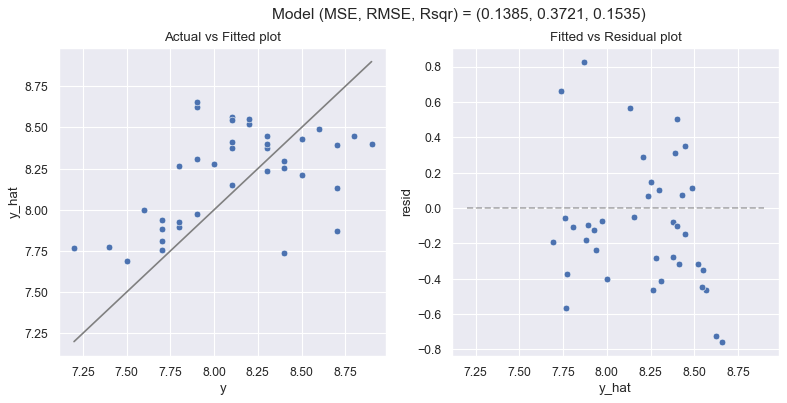

(0.13847132563431278, 0.37211735465349205, 0.1534606510755815)

In [44]:
model_fit(lasso_model, X_test, y_test, plot = True)

The value of $R^2$ is much lower, which means that the ability of our model to explain the variation of `imdb_rating` is weak. This is partly due to the small size of our samples. The features only have limited influence on the `imdb_rating`. But since we want to focus on the episode itself, we choose features and build the model which is probably the best one with these features.  

However, if we look at the MSE or RMSE, we can find that the error of our predict is quite low. Also, the upper right plot (Fitted vs Residual plot) tells that the residuals lie within (-1, 1), which means that the error of our predict is less than 1. This result is satisfactory.

Finally, we want to see the coefficients of our model.

In [45]:
coef = get_coefs(lasso_model)[1:]
feature = X_train.columns
all_coef = pd.DataFrame({'feature': feature, 'coefficient': coef})

In [46]:
imp_coef = all_coef.loc[all_coef['coefficient'] != 0]
imp_coef

,feature,coefficient
0,n_speak_char,0.130352
1,Angela,0.018048
3,Jim,0.022211
5,Michael,0.218170
10,Stanley,0.017834
17,Erin,-0.056592
18,Greg Daniels (director),0.025005
20,Ken Kwapis,0.003003
22,Paul Feig,0.039026
24,Gene Stupnitsky;Lee Eisenberg,0.012644


To be more intuitive, we plot these coefficients. The blue bars represent writers and green bars represent directors.

In [47]:
color = []
directors = ['Paul Feig','Ken Kwapis','Greg Daniels (director)','Ken Whittingham','Jeffrey Blitz']
writers = ['Greg Daniels (writer)','Gene Stupnitsky;Lee Eisenberg','Michael Schur','Paul Lieberstein','B.J. Novak']
for f in imp_coef['feature']:
    if f in directors:
        color.append('yellowgreen')
    elif f in writers:
        color.append('lightsteelblue')
    else:
        color.append('peru')

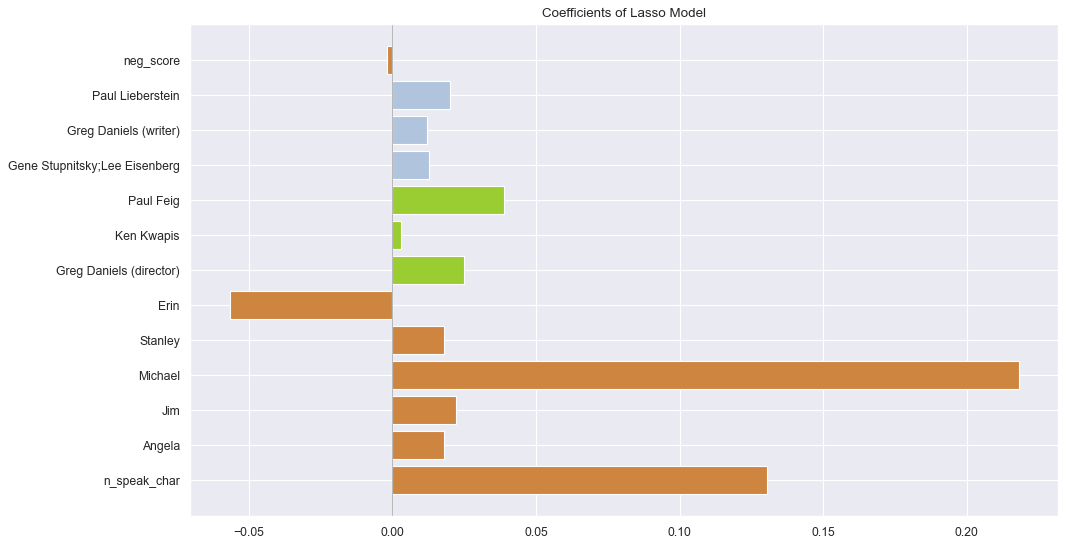

In [48]:
plt.barh(imp_coef['feature'], imp_coef['coefficient'], color = color)
plt.title('Coefficients of Lasso Model')
plt.axvline(x = 0, color = '0.5', linewidth = 0.5)

From the plot, we can see: 
- The character Michael has the largest positive effect on `imdb_rating`, while the character Erin has the most negative one.
- The regressor `n_speak_char` also has a significant positive influence.
- Three writers and three directors have non-zero coefficients. If the episode is produced by them, we may get a higher `imdb_rating`.
- The negative sentiment score has a very low negative coefficient.

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

#### add that we might want to condiser the timing of the episodes when they aired and that it could be cool to get data to see h
#### how much timing afffected the ratings

#### add idea about adjusted-IMDB rating based on the amount of votes (takes in the correlation between votes and rating)


#### General overview
- What features we selected and why, what data sets we used


#### Model 



#### Limitations


#### Future improvements
- Remove episodes with a focus on one character
- IMDb adjusted rating using votes
- Weight each season by IMDb rating
- Time of the year from air date. Potentially could suggest at what time of the year to release an episode. 

- Put a cap on our target variable of IMDb rating, it should not exceed 10. 



<i>bl</i> <b>foo</b>

# Discussion




## EDA and Feature Engineering

The goal of this project is to provide recommendations on how to construct a reunion episode of the office with the highest IMDb rating. From our modeling we are hoping to find the importance and weight of features that would make the reunion episode the most successful and result in the highest IMDb score. For this reason, features that have no impact on the construction of the epiosde were dropped as they lacked relevance to the task at hand. Firstly, 'season', 'episode number' and 'air date' were dropped as these are not features that we can provide recommendations on. Secondly, although 'votes' was highly correlated with IMDb rating, there is a problem of causation. An episode will receive high votes after it is aired, and it is not a feature that goes into the production of an episode. It was consequently dropped. 


In the data pre-processing, we combined the given data set with an additional data set called "schrutepy" which contains the number of lines spoken by each character for each episode along with a full script for each episode. Due to the addition of this new dataset, the feature 'main_chars' was dropped from the initial data set. The updated data set contains all the main characters which were provided in the initial dataset under the feature 'main_chars'.


We decided to drop the feature 'n_words' from the original data set as we found that it was highly correlated with the feature 'n_lines' so that our model performed better due to the reduced collinearity. From there we feature engineered 'n_lines' by dividing the number of lines per main character by 'n_lines' effectively creating new features that can be thought of as character presence. Physically, this represents the percentage of lines that each main character speaks per episode. Due to this combination of features, we could then drop 'n_lines' entirely. 

Finally, we decided not to include all directors and writers in the model. We decided that for both writers and directors, consistency (low standard deviation of IMDb ratings) and experience was as important as mean rating. In our final dataset, we included the top 5 directors and writers by mean IMDb rating with each one needing at least 5 episodes directed/written. This threshold frequency of 5 can be thought of as an 'experience' filter. We used dummy encoding for the writers and directors (1 if they contributed, 0 if they did not). This threshold of 5 is an arbitrary number and could have been changed, resulting in different results from our model. This is a limitation of the method in which we used. There is a tradeoff here between model complexity & computational cost and model accuracy for predicting the best possible writer/director. 

Lastly, we implemented a package called Vader which analyses the sentiment of each episode based on the script. The package returns a sentiment score for how positive, negative or neutral an episode is on a scale from 0 to 1. 

Our final data set thus includes the following features for the 186 different episodes:
- IMDB rating
- n_speak_chars
- character presence (17 columns for 17 characters)
- top 5 directors
- top 5 writers
- positive sentiment score
- negative sentiment score


A big improvement that can be done in the future for the EDA is to remove episodes from our dataset where the focus is set on only one character as some of them have very high IMDb scores. These episodes are not representative of the whole dataset of episodes and should be classified seperately to something like a reunion episode in which the focus is on multiple characters and not just a singular character.



## Modeling and Evaluation


For the 


## Recommendations

Based off of our model results we recommend the following:

1. The episode should be directed by ___
2. The episode should be written by Paul Lieberstein
3. The following characters should definetely be present in the episode: Stanley, Michael, Jim and Angela
4. The most lines should be given to each character in the following order: Michael, Jim, Angela and Stanley
5. The more characters in the episode the better, there are many characters with zero individual presence weighting, but when all of them are combined together the episode will be more successful. 
6. The character 'Erin' should not appear in the reunion episode as she has a negative impact on the episode rating
7. The script should overall have a very positive sentiment, any perceived negativeness in the script may decrease the episode rating. 

With the above recommendations, we have created a sample dummy row with the above recommendations and fit it to our model to see what the predicted IMDb score should be. 



# Conclusion








## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from

### INSERT reference to shrutepy here

Transformation:

I.K. Yeo and R.A. Johnson, “A new family of power transformations to improve normality or symmetry.” Biometrika, 87(4), pp.954-959, (2000).

Sentiment Package:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.